Teste técnico - Risk Analyst Cloudwalk.

In [177]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np


After importing the libs we are gona use. 
It is important to import and sanitize the data to be trained in our model

In [178]:
dataset = pd.read_csv('transactions.csv')

def clean_card_number(card):
    return int(''.join(filter(str.isdigit, card)))
dataset['card_number'] = dataset['card_number'].apply(clean_card_number)



'''#######################################################################'''

# Convert 'transaction_date' to datetime
dataset['transaction_date'] = pd.to_datetime(dataset['transaction_date'])

# Extract hour and minute components separately
# And Combine hour and minute components into a single integer
dataset['transaction_hour'] = dataset['transaction_date'].dt.hour.astype(int)
dataset['transaction_minute'] = dataset['transaction_date'].dt.minute.astype(int)
dataset['transaction_hour_minute'] = dataset['transaction_hour'] * 100 + dataset['transaction_minute']

# Drop the separate hour and minute columns for irrelevancy
dataset.drop(columns=['transaction_hour', 'transaction_minute'], inplace=True)

'''#######################################################################'''

dataset['transaction_date'] = dataset['transaction_date'].astype(int)

print(dataset.head(1))



   transaction_id  merchant_id  user_id  card_number     transaction_date  \
0        21320398        29744    97051   4345059116  1575242192812632000   

   transaction_amount  device_id  has_cbk  transaction_hour_minute  
0              374.56   285475.0    False                     2316  


Lets first try to pull out useful data from the dataset before trying to create and apply any models and the detection mechanism

In [179]:
print('Transações legítimas (FALSE) vs Fraudes (TRUE):')
print(dataset['has_cbk'].value_counts())

print()
print('Integridade de dados:')
missing_values = dataset.isnull().sum()
print(missing_values)

# Changes the missing device ids to 0
dataset['device_id'] = dataset['device_id'].fillna(0)


Transações legítimas (FALSE) vs Fraudes (TRUE):
False    2808
True      391
Name: has_cbk, dtype: int64

Integridade de dados:
transaction_id               0
merchant_id                  0
user_id                      0
card_number                  0
transaction_date             0
transaction_amount           0
device_id                  830
has_cbk                      0
transaction_hour_minute      0
dtype: int64


There are 3199 transactions in total, of which, 391 (12%) frauds and 2808 (88%) legitimate transactions.

And we also see that we have 830 transactions where the device id is missing, which cannot be discarded, because they present real use data, so a workaround this issue has to be developed.

Searching manually in the dataset, I found that 67 out of the 830 (8%)transactions lacking device ids were fraudulent, so the lack of device id has no relevant effect on the fraud amount on first sight. 

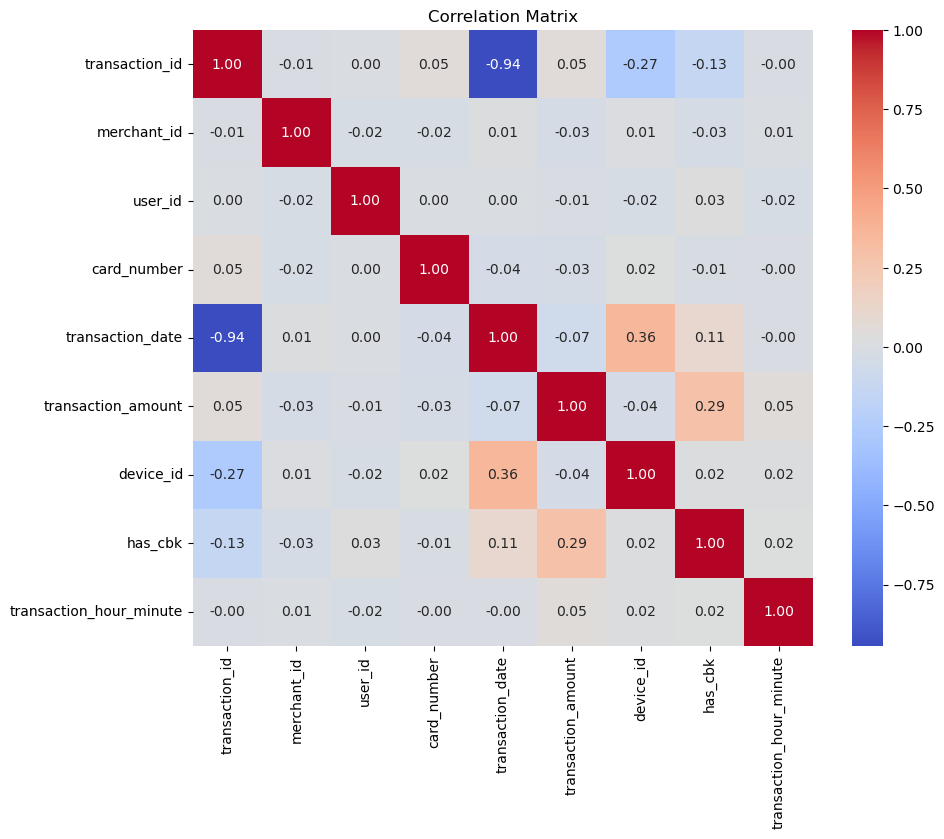

In [180]:
corr_matrix = dataset.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix')
plt.show()



From the correlation, it is possible to see that most of the characteristics have little to no correlation to has_cbk (the variable that tells if the transaction was fraudulent)

Accuracy: 0.859375
Confusion Matrix:
[[550   0]
 [ 90   0]]


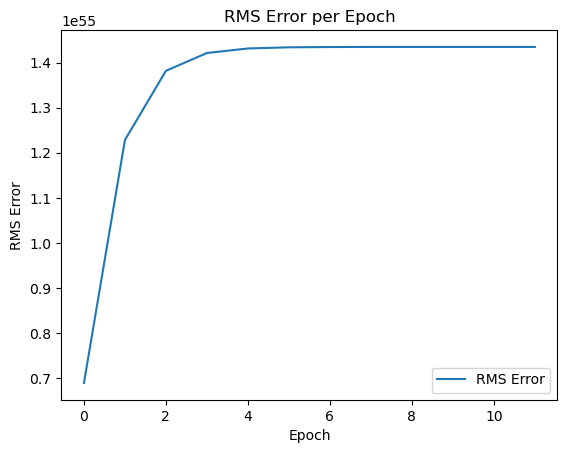

In [188]:
X = dataset.drop('has_cbk', axis=1)
y = dataset['has_cbk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8), activation='relu', solver='sgd', max_iter=500, random_state=42) 

model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)



# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


loss_curve = model.loss_curve_

# Plotting RMS error per epoch
plt.plot(np.sqrt(loss_curve), label='RMS Error')
plt.title('RMS Error per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMS Error')
plt.legend()
plt.show()

In [193]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Data preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=45)

# Model training
model = LogisticRegression()
model.fit(X_train, y_train)

# Model evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)


              precision    recall  f1-score   support

       False       0.88      0.98      0.93       557
        True       0.47      0.10      0.16        83

    accuracy                           0.87       640
   macro avg       0.68      0.54      0.54       640
weighted avg       0.83      0.87      0.83       640

[[548   9]
 [ 75   8]]


In [196]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_features,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

ModuleNotFoundError: No module named 'tensorflow'